In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import copy

# --- 1. Set Up Hyperparameters & Configuration ---
# Set a seed for reproducibility
torch.manual_seed(42)
random.seed(42)

NUM_CLIENTS = 3       # M=3 clients [cite: 105]
NUM_ROUNDS = 10       # Run for 10 iterations [cite: 115]
LEARNING_RATE = 0.01
TOTAL_SAMPLES = 60000  # Use a subset of MNIST for speed [cite: 104]
SAMPLES_PER_CLIENT = TOTAL_SAMPLES // NUM_CLIENTS # Evenly split [cite: 105, 106]

# Ensure data split is even
assert TOTAL_SAMPLES % NUM_CLIENTS == 0

# --- 2. Define a Small Model ---
# A simple 2-layer MLP as requested [cite: 107]
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# --- 3. Utility Function for Comparison ---
def compare_models(model1, model2):
    """
    Computes the L2 norm of the difference between model parameters.
    [cite: 118]
    """
    params1 = torch.cat([p.data.view(-1) for p in model1.parameters()])
    params2 = torch.cat([p.data.view(-1) for p in model2.parameters()])
    return torch.norm(params1 - params2, p=2).item()

# --- 4. Load and Partition Data ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full training dataset
full_train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# Create an IID split across clients [cite: 105]
# We'll use a subset of the first TOTAL_SAMPLES
indices = list(range(TOTAL_SAMPLES))
random.shuffle(indices)  # Shuffle indices for IID distribution

# Assign indices to each client
client_indices = [
    indices[i:i + SAMPLES_PER_CLIENT]
    for i in range(0, TOTAL_SAMPLES, SAMPLES_PER_CLIENT)
]

# Create client datasets and dataloaders
client_loaders = []
for idx in client_indices:
    client_dataset = Subset(full_train_dataset, idx)
    # Key: Batch size is the *entire* local dataset [cite: 109]
    loader = DataLoader(client_dataset, batch_size=SAMPLES_PER_CLIENT, shuffle=False)
    client_loaders.append(loader)

# Create centralized dataset and dataloader
centralized_dataset = Subset(full_train_dataset, list(range(TOTAL_SAMPLES)))
# Key: Batch size is the *entire combined* dataset [cite: 114]
centralized_loader = DataLoader(
    centralized_dataset, batch_size=TOTAL_SAMPLES, shuffle=False
)

print(f"--- Setup ---")
print(f"Total Clients: {NUM_CLIENTS}")
print(f"Total Data: {TOTAL_SAMPLES} samples")
print(f"Data per Client: {SAMPLES_PER_CLIENT} samples (IID)")
print(f"Rounds to run: {NUM_ROUNDS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"-----------------")

# --- 5. Initialize Models and Optimizers ---
# Ensure both models start with the *exact same* initial weights [cite: 113]
initial_model = SimpleMLP()
centralized_model = copy.deepcopy(initial_model)
fed_model = copy.deepcopy(initial_model)

# Centralized setup
centralized_optimizer = optim.SGD(
    centralized_model.parameters(), lr=LEARNING_RATE
)
criterion = nn.CrossEntropyLoss()

# Get the single, full batch of centralized data
central_images, central_labels = next(iter(centralized_loader))

# Get the single, full batch for each client
client_data = [next(iter(loader)) for loader in client_loaders]

# --- 6. Run Parallel Training and Compare ---
print("Running simulation...")
print("Round | Centralized Loss | FedSGD Avg. Loss | Model Diff (L2 Norm)")
print("-----------------------------------------------------------------")

centralized_losses = []
fed_losses = []
model_diffs = []

for round_num in range(NUM_ROUNDS):

    # === A: Centralized SGD Step === [cite: 111]
    centralized_optimizer.zero_grad()
    outputs = centralized_model(central_images)
    central_loss = criterion(outputs, central_labels)
    central_loss.backward()
    centralized_optimizer.step()
    centralized_losses.append(central_loss.item())

    # === B: FedSGD Round (K=1) === [cite: 108]
    global_weights = fed_model.state_dict()
    client_updates = []
    round_total_loss = 0.0

    # All clients participate [cite: 100]
    for i in range(NUM_CLIENTS):
        client_model = SimpleMLP()
        client_model.load_state_dict(global_weights)
        client_optimizer = optim.SGD(client_model.parameters(), lr=LEARNING_RATE)

        # Get this client's full batch
        images, labels = client_data[i]

        # Perform one local step on all its data [cite: 109]
        client_optimizer.zero_grad()
        client_outputs = client_model(images)
        client_loss = criterion(client_outputs, labels)
        client_loss.backward()
        client_optimizer.step()

        # Save the client's new weights
        client_updates.append(client_model.state_dict())
        # Weight loss by N_i (size of client data) 
        round_total_loss += client_loss.item() * len(labels)

    # Server Aggregation (FedAvg) [cite: 28, 30]
    new_global_weights = {}
    for key in global_weights.keys():
        # N_i/N = SAMPLES_PER_CLIENT / TOTAL_SAMPLES = 1 / NUM_CLIENTS
        weighting_factor = 1.0 / NUM_CLIENTS
        
        # Sum up weighted updates
        # Using SAMPLES_PER_CLIENT / TOTAL_SAMPLES is more general
        weighted_sum = torch.zeros_like(global_weights[key])
        for i in range(NUM_CLIENTS):
            weighted_sum += client_updates[i][key] * (SAMPLES_PER_CLIENT / TOTAL_SAMPLES)
        
        # In this special case (equal data), this is just a simple average
        # new_global_weights[key] = torch.stack(
        #     [client_updates[i][key] for i in range(NUM_CLIENTS)]
        # ).mean(dim=0)
        
        new_global_weights[key] = weighted_sum


    fed_model.load_state_dict(new_global_weights)
    
    # Calculate weighted average loss for the round
    avg_fed_loss = round_total_loss / TOTAL_SAMPLES
    fed_losses.append(avg_fed_loss)

    # === C: Compare Models === [cite: 116]
    diff = compare_models(centralized_model, fed_model)
    model_diffs.append(diff)

    print(
        f"  {round_num + 1: <3} |     {central_loss.item():.6f}     |     {avg_fed_loss:.6f}     |   {diff:.2e}"
    )

print("-----------------------------------------------------------------")
print("Simulation complete.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.74MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.25MB/s]


--- Setup ---
Total Clients: 3
Total Data: 60000 samples
Data per Client: 20000 samples (IID)
Rounds to run: 10
Learning Rate: 0.01
-----------------
Running simulation...
Round | Centralized Loss | FedSGD Avg. Loss | Model Diff (L2 Norm)
-----------------------------------------------------------------
  1   |     2.282982     |     2.282982     |   3.85e-07
  2   |     2.265723     |     2.265723     |   6.21e-07
  3   |     2.248669     |     2.248670     |   8.42e-07
  4   |     2.231785     |     2.231785     |   1.09e-06
  5   |     2.215039     |     2.215039     |   1.30e-06
  6   |     2.198409     |     2.198409     |   1.51e-06
  7   |     2.181875     |     2.181875     |   1.72e-06
  8   |     2.165401     |     2.165401     |   1.94e-06
  9   |     2.148972     |     2.148972     |   2.16e-06
  10  |     2.132574     |     2.132573     |   2.40e-06
-----------------------------------------------------------------
Simulation complete.


Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 52.1MB/s]



--- Setup ---
Dataset: CIFAR-10
Model: SimpleCNN
Total Clients: 10
Data per Client: 5000 samples (IID)
Rounds to run: 15
Local LR: 0.01
Local Batch Size: 32
-----------------

--- Experiment 1: Varying K (Local Epochs) ---
Starting run: K=1, Fraction=1.0
  Round  1/15 | Test Acc:  38.38% | Test Loss: 1.7572 | Avg Div:    2.21 |Time: 13.86s
  Round  2/15 | Test Acc:  47.38% | Test Loss: 1.4756 | Avg Div:    2.26 |Time: 12.53s
  Round  3/15 | Test Acc:  51.67% | Test Loss: 1.3732 | Avg Div:    2.01 |Time: 12.65s
  Round  4/15 | Test Acc:  54.79% | Test Loss: 1.2777 | Avg Div:    2.01 |Time: 12.34s
  Round  5/15 | Test Acc:  56.50% | Test Loss: 1.2251 | Avg Div:    2.09 |Time: 12.65s
  Round  6/15 | Test Acc:  58.85% | Test Loss: 1.1630 | Avg Div:    2.18 |Time: 12.69s
  Round  7/15 | Test Acc:  60.49% | Test Loss: 1.1214 | Avg Div:    2.27 |Time: 12.80s
  Round  8/15 | Test Acc:  61.90% | Test Loss: 1.0733 | Avg Div:    2.35 |Time: 12.47s
  Round  9/15 | Test Acc:  63.04% | Test Loss: 1

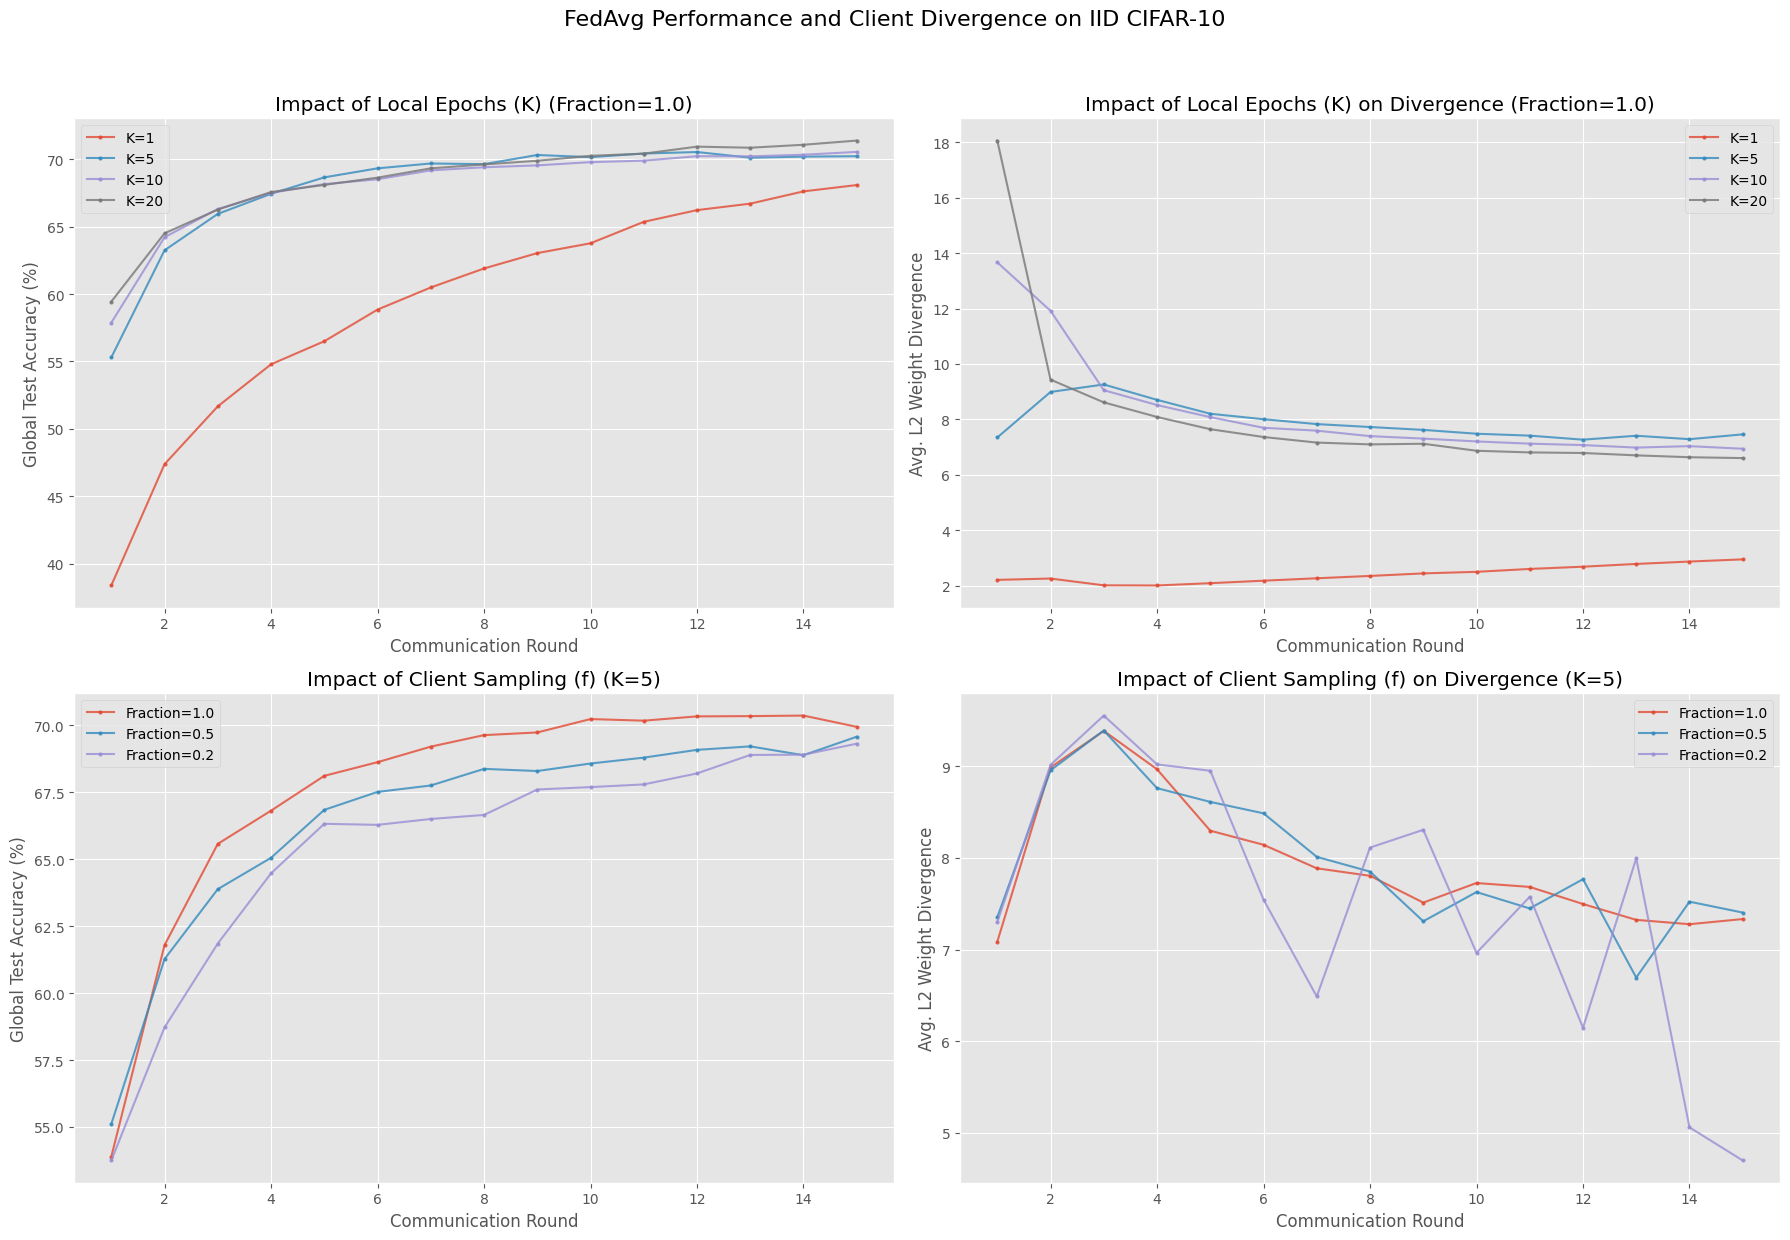

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import time

# --- 1. Set Up Hyperparameters & Configuration ---
# Set seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

NUM_CLIENTS = 10      # Use 10 clients
TOTAL_TRAIN_SAMPLES = 50000 # CIFAR-10 has 50k training images
SAMPLES_PER_CLIENT = TOTAL_TRAIN_SAMPLES // NUM_CLIENTS # 5000 each
LEARNING_RATE = 0.01
NUM_ROUNDS = 15       # Run for 50 communication rounds
LOCAL_BATCH_SIZE = 32 # Batch size for local client training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Experiment 1 Params (Vary K)
K_VALUES = [1, 5, 10, 20]      #
FRAC_K_EXP = 1.0              # Full participation

# Experiment 2 Params (Vary Fraction)
FRAC_VALUES = [1.0, 0.5, 0.2]  #
K_FRAC_EXP = 5                # Fixed K=5


# --- 2. Define the Model (Simple CNN for CIFAR-10) ---
#
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Input: 3x32x32
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        # -> 16x32x32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # -> 16x16x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        # -> 32x16x16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # -> 32x8x8
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10) # 10 classes for CIFAR-10

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# --- 3. Load and Partition Data (IID) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize for CIFAR-10
])

# Load train and test datasets
full_train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)

# Create an IID split across clients
indices = list(range(TOTAL_TRAIN_SAMPLES))
random.shuffle(indices)

# Assign indices to each client
client_indices = [
    indices[i:i + SAMPLES_PER_CLIENT]
    for i in range(0, TOTAL_TRAIN_SAMPLES, SAMPLES_PER_CLIENT)
]

# Create client dataloaders
client_loaders = []
for idx in client_indices:
    client_dataset = Subset(full_train_dataset, idx)
    loader = DataLoader(
        client_dataset,
        batch_size=LOCAL_BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )
    client_loaders.append(loader)

print(f"\n--- Setup ---")
print(f"Dataset: CIFAR-10")
print(f"Model: SimpleCNN")
print(f"Total Clients: {NUM_CLIENTS}")
print(f"Data per Client: {SAMPLES_PER_CLIENT} samples (IID)")
print(f"Rounds to run: {NUM_ROUNDS}")
print(f"Local LR: {LEARNING_RATE}")
print(f"Local Batch Size: {LOCAL_BATCH_SIZE}")
print(f"-----------------\n")

# --- 4. Define Federated Learning Helper Functions ---

def client_update(model_state, client_loader, k_epochs, lr):
    """
    Performs K local epochs of training on a client.
   
    """
    model = SimpleCNN().to(DEVICE)
    model.load_state_dict(model_state)
    model.train()
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    for _ in range(k_epochs):
        for images, labels in client_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
    return model.state_dict()

def server_aggregate(client_models):
    """
    Performs simple average of client model parameters.
    This works because we have an equal IID split (N_i/N_selected = 1/m).
   
    """
    # Get keys from the first model
    keys = client_models[0].keys()
    num_clients = len(client_models)
    new_global_weights = {}
    
    for key in keys:
        # Sum up all client weights for this key
        stacked_weights = torch.stack([model[key] for model in client_models])
        # Compute the average
        new_global_weights[key] = torch.mean(stacked_weights, dim=0)
        
    return new_global_weights

def evaluate_model(model, test_loader):
    """
    Evaluates the global model on the test set.
    """
    model.to(DEVICE)
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    return accuracy, avg_loss

def flatten_weights(state_dict):
    """
    Flattens all parameters from a state_dict into a single 1D tensor
    for L2 norm calculation.
    """
    # Move all tensors to CPU for consistent calculation
    flat_params = [
        p.detach().cpu().flatten() for p in state_dict.values()
    ]
    return torch.cat(flat_params)

# --- 5. Main Experiment Runner ---

def run_fedavg_experiment(k_epochs, client_fraction, num_rounds):
    """
    Runs a full FedAvg simulation for given parameters.
    """
    print(f"Starting run: K={k_epochs}, Fraction={client_fraction}")
    
    # Initialize a new global model for this run
    global_model = SimpleCNN()
    
    accuracy_history = []
    divergence_history = []
    
    # Calculate number of clients to sample each round
    num_selected_clients = max(1, int(client_fraction * NUM_CLIENTS))
    
    for round_num in range(num_rounds):
        start_time = time.time()
        
        # Get current global model state
        global_weights = global_model.state_dict()
        flat_global_weights = flatten_weights(global_weights)
        
        # Client Sampling
        selected_client_indices = random.sample(
            range(NUM_CLIENTS), num_selected_clients
        )
        
        client_updates = []
        
        # Broadcast and Local Training
        for client_id in selected_client_indices:
            loader = client_loaders[client_id]
            # Perform local training
            local_model_state = client_update(
                copy.deepcopy(global_weights), 
                loader, 
                k_epochs, 
                LEARNING_RATE
            )
            client_updates.append(local_model_state)
            
        round_divergences = []
        for local_state in client_updates:
            # This is theta_i(t, K) (local model i after K steps)
            flat_local_weights = flatten_weights(local_state)
            
            # Calculate L2 norm: || theta_i(t, K) - theta_g_t ||
            l2_divergence = torch.norm(
                flat_local_weights - flat_global_weights, p=2
            )
            round_divergences.append(l2_divergence.item())
        
        # Calculate average divergence for the round (as per your formula)
        avg_divergence = sum(round_divergences) / len(round_divergences)
        divergence_history.append(avg_divergence)
        
        # Aggregation
        new_global_weights = server_aggregate(client_updates)
        global_model.load_state_dict(new_global_weights)
        
        # Evaluate
        acc, loss = evaluate_model(global_model, test_loader)
        accuracy_history.append(acc)
        
        elapsed = time.time() - start_time
        print(f"  Round {round_num+1:2d}/{num_rounds} | "
              f"Test Acc: {acc:6.2f}% | "
              f"Test Loss: {loss:.4f} | "
              f"Avg Div: {avg_divergence:7.2f} |"
              f"Time: {elapsed:.2f}s")
    
    print(f"Run finished: K={k_epochs}, Fraction={client_fraction}\n")
    return accuracy_history, divergence_history

# --- 6. Run Experiments and Store Results ---

results_k = {}
results_frac = {}

print("--- Experiment 1: Varying K (Local Epochs) ---")
for k in K_VALUES:
    # *** MODIFIED: Unpack tuple of results ***
    acc_hist, div_hist = run_fedavg_experiment(
        k_epochs=k,
        client_fraction=FRAC_K_EXP,
        num_rounds=NUM_ROUNDS
    )
    # *** MODIFIED: Store tuple of results ***
    results_k[f"K={k}"] = (acc_hist, div_hist)

# Experiment 2: Vary f (Client Fraction)
print("\n--- Experiment 2: Varying f (Client Fraction) ---")
for f in FRAC_VALUES:
    acc_hist, div_hist = run_fedavg_experiment(
        k_epochs=K_FRAC_EXP,
        client_fraction=f,
        num_rounds=NUM_ROUNDS
    )
    results_frac[f"Fraction={f}"] = (acc_hist, div_hist)
    
print("\nAll experiments complete.")

# --- 7. Plot Results (MODIFIED) ---

plt.style.use('ggplot')
# *** MODIFIED: Create a 2x2 grid for 4 plots ***
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(18, 12)
)
fig.suptitle(
    'FedAvg Performance and Client Divergence on IID CIFAR-10', 
    fontsize=16, y=1.03
)
rounds = list(range(1, NUM_ROUNDS + 1))

# Plot 1: Accuracy vs. Rounds for different K
ax1.set_title(f'Impact of Local Epochs (K) (Fraction=1.0)')
ax1.set_xlabel('Communication Round')
ax1.set_ylabel('Global Test Accuracy (%)')
for label, (acc_history, _) in results_k.items():
    ax1.plot(rounds, acc_history, label=label, marker='o', markersize=2, alpha=0.8)
ax1.legend()
ax1.grid(True)

# *** NEW: Plot 2: Divergence vs. Rounds for different K ***
ax2.set_title(f'Impact of Local Epochs (K) on Divergence (Fraction=1.0)')
ax2.set_xlabel('Communication Round')
ax2.set_ylabel('Avg. L2 Weight Divergence')
for label, (_, div_history) in results_k.items():
    ax2.plot(rounds, div_history, label=label, marker='o', markersize=2, alpha=0.8)
ax2.legend()
ax2.grid(True)

# Plot 3: Accuracy vs. Rounds for different fractions
ax3.set_title(f'Impact of Client Sampling (f) (K={K_FRAC_EXP})')
ax3.set_xlabel('Communication Round')
ax3.set_ylabel('Global Test Accuracy (%)')
for label, (acc_history, _) in results_frac.items():
    ax3.plot(rounds, acc_history, label=label, marker='o', markersize=2, alpha=0.8)
ax3.legend()
ax3.grid(True)

# *** NEW: Plot 4: Divergence vs. Rounds for different fractions ***
ax4.set_title(f'Impact of Client Sampling (f) on Divergence (K={K_FRAC_EXP})')
ax4.set_xlabel('Communication Round')
ax4.set_ylabel('Avg. L2 Weight Divergence')
for label, (_, div_history) in results_frac.items():
    ax4.plot(rounds, div_history, label=label, marker='o', markersize=2, alpha=0.8)
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.savefig("task2_fedavg_experiments_with_divergence.png")
print("\nPlots saved to 'task2_fedavg_experiments_with_divergence.png'")
# To display the plot in environments like Jupyter:
# plt.show()